In [103]:
%matplotlib inline
import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy as np
import os
import re
from utilities import get_ticks
from matplotlib import cm, ticker
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 

mu_0 = 1.257e-6
R_M = 2440e3 #m

# Save frame slices for making movies

In [107]:
#########################

# High-level user input
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/"    # Directory with data 
start_time = 135                                                # What is the start time of the dataset?
t_bound = [135,303]                                               # Start and stop times for the GIF
dt = 0.2                                                     # What is the timestep between files?

'''
Choose plot type from existing presets;

"pic_E_y":  flow vectors and duskward convective field
Recommended settings: (xy)
xlims=[-2.2,0.2]
ylims=[-1.2,1.2]
shape=[160,160]

"pic_dipolarization_zoom": pressure and field lines to show particular dipolarization event in detail
Recommended settings: (xz)
xlims=[-3,-0.75]
ylims=[-0.5,1.0]
shape=[225,150] 

"pic_Jy": find xz line of the current sheet (xz)


"pic_currentsheet": eletric field and Bz in current sheet
Recommended settings: (xz)
xlims=[-3.5,0.2]
ylims=[-1.2,1.2]
shape=[160,160] 

"bz1": perturbation magnetic field in near-planet current sheet (xy)
xlims=[-2.4,-0.4]
ylims=[-1,1]
shape=[200,200] 

"pressure_anisotropy": plot of pressure difference between perpendicular and parallel
xlims=[-2.4,-0.4]
ylims=[-1,1]
shape=[200,200] 

"pic_currentsheet2": just bz in the current sheet (xy)
xlims=[-2.2,0.2]
ylims=[-1.2,1.2]
shape=[160,160] 
'''

plot_preset = "pic_Jy"
slice = "xz"                                                   # Set plane of slice ("xy" or "xz") or "sphere" for particle psd
data_type = "fluid" # "cut" or "fluid"
particle_type = "ion" # Either "ion" or "electron"; relevant for choosing which pressure tensor to display for "pressure_anisotropy"
z_plane = 0.4

# Grid settings/location of particle sphere
xlims=[-3,-0.75]
ylims=[-0.5,1.0]
shape=[225,150] 
loc = [-1.0,0,0.2] # location of particle sphere
a = 0.1 # radius of particle sphere

#########################

# First, get list of files in directory
all_files = [os.path.join(dir, o) for o in os.listdir(dir) 
                    if os.path.isdir(os.path.join(dir,o))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    if data_type=="fluid":
        match = re.search(str(dir+"3d_fluid_region0_.*"),file)
        if match != None:
            files.append(file)
    elif data_type=="cut":
        match = re.search(str(dir+"cut_particle_region0.*"),file)
        if match != None:
            files.append(file)
files.sort()
files = files
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Define utility functions
def get_grad(slice,i_coords,j_coords):
    # Input: a numpy-format slice of the data, in the right orientation such that imshow / contourf works correctly. 
    # Also pass dc.x.value, dc.y.value to give the i / j coords.
    # Output: the gradient of the parameter, in the i / j direction (i.e. x,y or x,z), whichever plane the slice is in.
    
    # Extract the j and i dimensions 
    j_size,i_size = slice.shape

    # Find step size
    di = i_coords[1]-i_coords[0]
    dj = j_coords[1]-j_coords[0]

    # Define empty arrays to save output to
    d_di = np.zeros_like(slice)
    d_dj = np.zeros_like(slice)

    # First past compute gradient (error: huge gradients at edge of boundary e.g bz drops to 0 at inner edge in one cell)
    #d_di,d_dj = np.gradient(slice,di,dj)

    # Begin gradient computation loop
    for j in range(1,j_size-1):
        for i in range(1,i_size-1):
            # Compute d_di:
            d_di[j,i] = (slice[j,i+1] - slice[j,i-1]) / (2*di)
            # Compute d_dj:
            d_dj[j,i] = (slice[j+1,i] - slice[j-1,i]) / (2*dj)

    # Fix large gradients at edges of pic domain
    for j in range(1,j_size-1):
        for i in range(1,i_size-1):
            if slice[j,i]==0 and slice[j,i+1]!=0: # left edge
                d_di[j,i] = 0 # set gradient outside pic to 0
                d_dj[j,i] = 0
                d_di[j,i+1] = d_di[j,i+2] # set outermost cell gradient to same value as one further in
                d_dj[j,i+1] = d_dj[j,i+2]
            if slice[j,i]==0 and slice[j,i-1]!=0: # right edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j,i-1] = d_di[j,i-2] 
                d_dj[j,i-1] = d_dj[j,i-2]
            if slice[j,i]==0 and slice[j+1,i]!=0: # bottom edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j+1,i] = d_di[j+2,i] 
                d_dj[j+1,i] = d_dj[j+2,i]
            if slice[j,i]==0 and slice[j-1,i]!=0: # top edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j-1,i] = d_di[j-2,i] 
                d_dj[j-1,i] = d_dj[j-2,i]
            #print("Value:",slice[j,i],"X:",i_coords[i],"Z:",j_coords[j])
    
    return d_di,d_dj

# Loop over each file, pull the data, make the plots, and save as .pngs in /frames
for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
    filename = str(named_files[time])
    print(filename)
    ds = fleks.load(filename)
    if slice=="xy":
        dc = ds.get_slice("z",z_plane)
        #print(dc)
    elif slice=="xz":
        dc = ds.get_slice("y",0.0)
    elif slice=="sphere":
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
    
    # Plot!!

    # Use preset
    if plot_preset == "pic_E_y":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        v = dc.evaluate_expression("Ey")
        ux = np.array(dc.evaluate_expression("uxS1").T)
        uy = np.array(dc.evaluate_expression("uyS1").T)
        vmin = v.min().v
        vmax = v.max().v
        nlevels = 200 
        levels = np.linspace(-50, 50, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(v.T)/1e3, levels=levels, cmap='bwr')
        ticks = get_ticks(-50, 50)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$E_y$ [mV/m]',fontsize=12)
        quiver_skip=10
        ax.quiver(dc.x.value[::quiver_skip], dc.y.value[::quiver_skip],ux[::quiver_skip,::quiver_skip], uy[::quiver_skip,::quiver_skip],color="grey")
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Convection field at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_dipolarization_zoom":
        fig, ax = plt.subplots(figsize=(12,7))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        Bx = dc.evaluate_expression("Bx")
        P = dc.evaluate_expression("pxxS1")+dc.evaluate_expression("pyyS1")+dc.evaluate_expression("pzzS1")+dc.evaluate_expression("pxxS0")+dc.evaluate_expression("pyyS0")+dc.evaluate_expression("pzzS0")
        Bz = dc.evaluate_expression("Bz")
        vmin = -2
        vmax = 1.5
        nlevels = 21 
        levels=np.logspace(vmin,vmax,nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(P.T),levels=levels,norm = LogNorm())#norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))#, cmap='bwr')

        start_points = np.zeros([40,2])
        start_points[:,0]=np.linspace(xlims[0],xlims[1],40)
        start_points[:,1]=0.5 - np.linspace(0,0.1,40)
        
        ax.streamplot(dc.x.value,dc.y.value, np.array(Bx.T),np.array(Bz.T),color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        formatter = LogFormatter(10, labelOnlyBase=False) 
        clb = fig.colorbar(cs, ax=ax,norm=LogNorm())#, format=formatter)            
        clb.locator = LogLocator()
        clb.formatter = LogFormatterSciNotation()
        clb.ax.set_title('p [nPa]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Plasma pressure at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_Jy":
        # Set up plot environment
        fig, ax = plt.subplots(figsize=(12,7))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)

        # Read in B field data
        Bx = np.array(dc.evaluate_expression("Bx").T)
        Bz = np.array(dc.evaluate_expression("Bz").T)

        # Compute B-field gradients, converting from nT/R_M to T/m
        dBx_dx, dBx_dz = get_grad(Bx*1e-9/R_M,dc.x.value, dc.y.value)
        dBz_dx, dBz_dz = get_grad(Bz*1e-9/R_M,dc.x.value, dc.y.value)

        # Compute curl [mA / m^2]
        Jy = (dBx_dz-dBz_dx) / mu_0 * 1e6

        # Colorplot
        vmin = -0.5
        vmax = 0.5
        nlevels = 51 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, Jy, levels=levels, cmap='bwr')

        # Add colorbar
        clb = fig.colorbar(cs, ax=ax)
        clb.ax.set_title('$J_y$ [mA/m$^2$]',fontsize=12)

        # Configure plot plane
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Current density at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_currentsheet":
        fig, ax = plt.subplots(ncols=2,figsize=(25,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        #plot v
        v = np.sqrt(dc.evaluate_expression("uxS1")**2 + dc.evaluate_expression("uyS1")**2)
        ux = np.array(dc.evaluate_expression("uxS1").T)
        uy = np.array(dc.evaluate_expression("uyS1").T)
        vmin = v.min().v
        vmax = v.max().v
        nlevels = 200 
        levels = np.logspace(0, 3, nlevels)
        cs = ax[0].contourf(dc.x.value, dc.y.value, np.array(v.T),levels=levels, cmap='rainbow',locator=ticker.LogLocator())
        clb0 = fig.colorbar(cs, ax=ax[0])                   
        clb0.ax.tick_params(labelsize=8)
        clb0.ax.set_title('$V$ [R$_M$/s]',fontsize=12)
        quiver_skip=10
        ax[0].quiver(dc.x.value[::quiver_skip], dc.y.value[::quiver_skip],ux[::quiver_skip,::quiver_skip], uy[::quiver_skip,::quiver_skip],color="grey")
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Y [$R_M$]")
        ax[0].add_patch(outer)
        ax[0].add_patch(inner)
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("Convection field at t="+str(round(time,2))+"s"))

        #plot B
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        Bx = dc.evaluate_expression("Bx")
        Bz = dc.evaluate_expression("Bz")
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax[1].contourf(dc.x.value, dc.y.value, np.array(Bz.T), levels=levels, cmap='bwr')
        
        ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs, ax=ax[1],ticks=ticks)            
        clb1.ax.set_yticks(ticks)    
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Y [$R_M$]")
        ax[1].add_patch(outer)
        ax[1].add_patch(inner)
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].set_title(str("$B_z$ at t="+str(round(time,2))+"s"))

    elif plot_preset == "particles_uxuy":
        # broken for many reasons, and the particle data is featureless anyway.
        sp = ds.sphere(loc,a)
        plot = ds.plot_phase_region(sp, 'p_ux', 'p_uz', z_field,
                            unit_type="planet", x_bins=64, y_bins=64,domain_size=(-2550, 2550, -2550, 2550))
        #plot.set_colorbar_label(plot.fields[0], "Ion count")
        for var_name in plot.profile.field_data: 
            val = plot.profile.field_data[var_name] 
    
        x = plot.profile.x
        y = plot.profile.y

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.contourf(x,y,val,20,vmin = 0,vmax=700)
        im.set_clim(0,700)
        clb=fig.colorbar(im)

    elif plot_preset == "pic_currentsheet2":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        Bz = dc.evaluate_expression("Bz")
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(Bz.T), levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_{z}$ at t="+str(round(time,2))+"s"+"   z = "+str(z_plane)))
        fig.show()

    elif plot_preset == "bz1":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)

        # Extract Bz and remove units
        Bz_temp = dc.evaluate_expression("Bz")
        Bz = np.zeros(Bz_temp.shape)
        Bz[:,:] = Bz_temp[:,:]

        # Define meshgrids
        xx,yy = np.meshgrid(dc.x.value, dc.y.value)

        #Compute Bz1 
        #First compute dipole field strength, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz_dip = - 200.9 * (3*z_plane**2 - (xx**2+yy**2+z_plane**2))/((xx**2+yy**2+z_plane**2)**(5/2))
        # Then subtract this from modeled bz
        Bz1 = Bz.T - Bz_dip
        
        vmin = -100#-100
        vmax = 20
        nlevels = 91 
        levels = np.linspace(vmin, vmax, nlevels)
        
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(Bz1), cmap = 'viridis',levels=levels) #,cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_{z1}$ at t="+str(round(time,2))+"s"+"   z = "+str(z_plane)))
        fig.show()

    elif plot_preset == "pressure_anisotropy":
        
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        
        # Extract pressure terms and remove units
        if particle_type=="ion":
            pxxS1_temp = dc.evaluate_expression("pxxS1")
            pxyS1_temp = dc.evaluate_expression("pxyS1")
            pxzS1_temp = dc.evaluate_expression("pxzS1")
            pyyS1_temp = dc.evaluate_expression("pyyS1")
            pyzS1_temp = dc.evaluate_expression("pyzS1")
            pzzS1_temp = dc.evaluate_expression("pzzS1")
        elif particle_type=="electron":
            pxxS1_temp = dc.evaluate_expression("pxxS0")
            pxyS1_temp = dc.evaluate_expression("pxyS0")
            pxzS1_temp = dc.evaluate_expression("pxzS0")
            pyyS1_temp = dc.evaluate_expression("pyyS0")
            pyzS1_temp = dc.evaluate_expression("pyzS0")
            pzzS1_temp = dc.evaluate_expression("pzzS0")
        else:
            print("ERROR: invalid particle type!")
        pxxS1 = np.zeros(pxxS1_temp.T.shape)
        pxyS1 = np.zeros(pxyS1_temp.T.shape)
        pxzS1 = np.zeros(pxzS1_temp.T.shape)
        pyyS1 = np.zeros(pyyS1_temp.T.shape)
        pyzS1 = np.zeros(pyzS1_temp.T.shape)
        pzzS1 = np.zeros(pzzS1_temp.T.shape)
        pxxS1[:,:] = pxxS1_temp[:,:].T
        pxyS1[:,:] = pxyS1_temp[:,:].T
        pxzS1[:,:] = pxyS1_temp[:,:].T
        pyyS1[:,:] = pyyS1_temp[:,:].T
        pyzS1[:,:] = pyzS1_temp[:,:].T
        pzzS1[:,:] = pzzS1_temp[:,:].T

        # Extract magnetic terms and remove units
        Bx_temp = dc.evaluate_expression("Bx")
        By_temp = dc.evaluate_expression("By")
        Bz_temp = dc.evaluate_expression("Bz")
        Bx = np.zeros(Bx_temp.T.shape)
        By = np.zeros(By_temp.T.shape)
        Bz = np.zeros(Bz_temp.T.shape)
        Bx[:,:] = Bx_temp[:,:].T
        By[:,:] = By_temp[:,:].T
        Bz[:,:] = Bz_temp[:,:].T

        # Define meshgrids
        xx,yy = np.meshgrid(dc.x.value, dc.y.value)

        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]

        # Compute coordinate transformation matrix, A
        # The three columns of this matrix correspond to the first perpendicular component, the second, and the parallel component, respectively
        Axx = np.sqrt(1-bx**2)
        Axy = 0
        Axz = bx
        Ayx = -bx*by/np.sqrt(1-bx**2)
        Ayy = bz/np.sqrt(bz**2+by**2)
        Ayz = by
        Azx = -bx*bz/np.sqrt(1-bx**2)
        Azy = -by/np.sqrt(bz**2+by**2)
        Azz = bz

        # Transfrom the pressure tensor from pS1 (in cartesian) to P (in perp / perp / parallel coords): P = A x pS1
        # Note that pS1 is symmetric, so e.g. pxyS1 = pyxS1
        Pxx = Axx*pxxS1 + Axy*pxyS1 + Axz*pxzS1
        Pxy = Axx*pxyS1 + Axy*pyyS1 + Axz*pyzS1
        Pxz = Axx*pxzS1 + Axy*pyzS1 + Axz*pzzS1
        Pyx = Ayx*pxxS1 + Ayy*pxyS1 + Ayz*pxzS1
        Pyy = Ayx*pxyS1 + Ayy*pyyS1 + Ayz*pyzS1
        Pyz = Ayx*pxzS1 + Ayy*pyzS1 + Ayz*pzzS1
        Pzx = Azx*pxxS1 + Azy*pxyS1 + Azz*pxzS1
        Pzy = Azx*pxyS1 + Azy*pyyS1 + Azz*pyzS1
        Pzz = Azx*pxzS1 + Azy*pyzS1 + Azz*pzzS1

        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        P_anisotropy = Pzz - Pxx - Pyy / np.sqrt(Pzz**2+Pxx**2+Pyy**2)

        # Plot
        vmin = -1.5
        vmax = 1.5
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(P_anisotropy), levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('Normalized diff',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("parallel - perpendicular at t="+str(round(time,2))+"s"+"   z = "+str(z_plane))+"\n Particle type: "+particle_type)
        fig.show()
        
    # Save
    plt.savefig(str("/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun_plots/"+plot_preset+"_"+str(round(time,2))+'.png'),bbox_inches='tight')
    plt.close(fig)

yt : [INFO     ] 2024-08-12 11:46:14,702 Parameters: current_time              = 135.0
yt : [INFO     ] 2024-08-12 11:46:14,703 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:14,704 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:14,705 Parameters: domain_right_edge         = [1. 2. 2.]


142 files recognized!
/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000000_amrex
Plotting t 135.0


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_69318/4003733724.py:263: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
yt : [INFO     ] 2024-08-12 11:46:15,809 Parameters: current_time              = 135.20000868810553
yt : [INFO     ] 2024-08-12 11:46:15,809 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:15,810 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:15,811 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000104_amrex
Plotting t 135.2


yt : [INFO     ] 2024-08-12 11:46:16,943 Parameters: current_time              = 135.40176287854825
yt : [INFO     ] 2024-08-12 11:46:16,944 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:16,944 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:16,945 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000216_amrex
Plotting t 135.4


yt : [INFO     ] 2024-08-12 11:46:18,075 Parameters: current_time              = 135.6001333963198
yt : [INFO     ] 2024-08-12 11:46:18,076 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:18,077 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:18,077 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000324_amrex
Plotting t 135.6


yt : [INFO     ] 2024-08-12 11:46:19,231 Parameters: current_time              = 135.80092812998905
yt : [INFO     ] 2024-08-12 11:46:19,232 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:19,232 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:19,233 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000438_amrex
Plotting t 135.8


yt : [INFO     ] 2024-08-12 11:46:21,173 Parameters: current_time              = 136.00133957449802
yt : [INFO     ] 2024-08-12 11:46:21,173 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:21,174 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:21,175 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000549_amrex
Plotting t 136.0


yt : [INFO     ] 2024-08-12 11:46:22,331 Parameters: current_time              = 136.2010620222566
yt : [INFO     ] 2024-08-12 11:46:22,332 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:22,333 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:22,333 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000656_amrex
Plotting t 136.2


yt : [INFO     ] 2024-08-12 11:46:23,473 Parameters: current_time              = 136.4014282815098
yt : [INFO     ] 2024-08-12 11:46:23,473 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:23,474 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:23,474 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000766_amrex
Plotting t 136.4


yt : [INFO     ] 2024-08-12 11:46:24,634 Parameters: current_time              = 136.60141536902086
yt : [INFO     ] 2024-08-12 11:46:24,635 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:24,636 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:24,636 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000876_amrex
Plotting t 136.6


yt : [INFO     ] 2024-08-12 11:46:25,817 Parameters: current_time              = 136.8015747048821
yt : [INFO     ] 2024-08-12 11:46:25,818 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:25,818 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:25,819 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000981_amrex
Plotting t 136.8


yt : [INFO     ] 2024-08-12 11:46:26,949 Parameters: current_time              = 137.0007829797857
yt : [INFO     ] 2024-08-12 11:46:26,950 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:26,951 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:26,951 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001083_amrex
Plotting t 137.0


yt : [INFO     ] 2024-08-12 11:46:28,096 Parameters: current_time              = 137.20097049042084
yt : [INFO     ] 2024-08-12 11:46:28,097 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:28,098 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:28,098 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001187_amrex
Plotting t 137.2


yt : [INFO     ] 2024-08-12 11:46:29,241 Parameters: current_time              = 137.40030227361433
yt : [INFO     ] 2024-08-12 11:46:29,242 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:29,242 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:29,243 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001286_amrex
Plotting t 137.4


yt : [INFO     ] 2024-08-12 11:46:31,150 Parameters: current_time              = 137.60161285777713
yt : [INFO     ] 2024-08-12 11:46:31,151 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:31,152 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:31,153 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001391_amrex
Plotting t 137.6


yt : [INFO     ] 2024-08-12 11:46:32,292 Parameters: current_time              = 137.80172372155434
yt : [INFO     ] 2024-08-12 11:46:32,293 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:32,293 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:32,294 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001496_amrex
Plotting t 137.8


yt : [INFO     ] 2024-08-12 11:46:33,435 Parameters: current_time              = 138.0003495439726
yt : [INFO     ] 2024-08-12 11:46:33,435 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:33,436 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:33,437 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001597_amrex
Plotting t 138.0


yt : [INFO     ] 2024-08-12 11:46:34,609 Parameters: current_time              = 138.20077534179643
yt : [INFO     ] 2024-08-12 11:46:34,609 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:34,610 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:34,611 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001702_amrex
Plotting t 138.2


yt : [INFO     ] 2024-08-12 11:46:35,760 Parameters: current_time              = 138.4009871673815
yt : [INFO     ] 2024-08-12 11:46:35,761 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:35,762 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:35,762 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001808_amrex
Plotting t 138.4


yt : [INFO     ] 2024-08-12 11:46:36,891 Parameters: current_time              = 138.60069832807923
yt : [INFO     ] 2024-08-12 11:46:36,892 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:36,892 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:36,893 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001915_amrex
Plotting t 138.6


yt : [INFO     ] 2024-08-12 11:46:38,032 Parameters: current_time              = 138.8015772260759
yt : [INFO     ] 2024-08-12 11:46:38,033 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:38,033 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:38,034 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00002022_amrex
Plotting t 138.8


yt : [INFO     ] 2024-08-12 11:46:39,167 Parameters: current_time              = 139.00017845735312
yt : [INFO     ] 2024-08-12 11:46:39,168 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:39,169 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:39,169 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002126_amrex
Plotting t 139.0


yt : [INFO     ] 2024-08-12 11:46:40,298 Parameters: current_time              = 139.20131008404218
yt : [INFO     ] 2024-08-12 11:46:40,299 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:40,300 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:40,300 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002232_amrex
Plotting t 139.2


yt : [INFO     ] 2024-08-12 11:46:42,293 Parameters: current_time              = 139.40034366583404
yt : [INFO     ] 2024-08-12 11:46:42,294 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:42,294 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:42,295 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002336_amrex
Plotting t 139.4


yt : [INFO     ] 2024-08-12 11:46:43,453 Parameters: current_time              = 139.60066825686016
yt : [INFO     ] 2024-08-12 11:46:43,454 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:43,454 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:43,455 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002441_amrex
Plotting t 139.6


yt : [INFO     ] 2024-08-12 11:46:44,602 Parameters: current_time              = 139.8008025357148
yt : [INFO     ] 2024-08-12 11:46:44,603 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:44,604 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:44,604 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002543_amrex
Plotting t 139.8


yt : [INFO     ] 2024-08-12 11:46:45,778 Parameters: current_time              = 140.00169966710527
yt : [INFO     ] 2024-08-12 11:46:45,779 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:45,780 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:45,780 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002646_amrex
Plotting t 140.0


yt : [INFO     ] 2024-08-12 11:46:46,942 Parameters: current_time              = 140.2006962442681
yt : [INFO     ] 2024-08-12 11:46:46,943 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:46,943 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:46,944 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002752_amrex
Plotting t 140.2


yt : [INFO     ] 2024-08-12 11:46:48,089 Parameters: current_time              = 140.40044192675447
yt : [INFO     ] 2024-08-12 11:46:48,090 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:48,091 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:48,091 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002859_amrex
Plotting t 140.4


yt : [INFO     ] 2024-08-12 11:46:49,242 Parameters: current_time              = 140.60174286290095
yt : [INFO     ] 2024-08-12 11:46:49,242 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:49,243 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:49,244 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002968_amrex
Plotting t 140.6


yt : [INFO     ] 2024-08-12 11:46:50,385 Parameters: current_time              = 140.8013848862417
yt : [INFO     ] 2024-08-12 11:46:50,386 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:50,387 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:50,388 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00003077_amrex
Plotting t 140.8


yt : [INFO     ] 2024-08-12 11:46:51,530 Parameters: current_time              = 141.00157379951156
yt : [INFO     ] 2024-08-12 11:46:51,531 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:51,532 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:51,532 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003186_amrex
Plotting t 141.0


yt : [INFO     ] 2024-08-12 11:46:53,542 Parameters: current_time              = 141.2015641520777
yt : [INFO     ] 2024-08-12 11:46:53,543 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:53,544 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:53,545 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003299_amrex
Plotting t 141.2


yt : [INFO     ] 2024-08-12 11:46:54,728 Parameters: current_time              = 141.4007083411215
yt : [INFO     ] 2024-08-12 11:46:54,729 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:54,730 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:54,730 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003411_amrex
Plotting t 141.4


yt : [INFO     ] 2024-08-12 11:46:55,890 Parameters: current_time              = 141.601511176457
yt : [INFO     ] 2024-08-12 11:46:55,891 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:55,892 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:55,893 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003527_amrex
Plotting t 141.6


yt : [INFO     ] 2024-08-12 11:46:57,052 Parameters: current_time              = 141.80137737723788
yt : [INFO     ] 2024-08-12 11:46:57,053 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:57,054 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:57,054 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003644_amrex
Plotting t 141.8


yt : [INFO     ] 2024-08-12 11:46:58,222 Parameters: current_time              = 142.00081732844532
yt : [INFO     ] 2024-08-12 11:46:58,223 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:58,224 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:58,224 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00003758_amrex
Plotting t 142.0


yt : [INFO     ] 2024-08-12 11:46:59,374 Parameters: current_time              = 142.20066976785006
yt : [INFO     ] 2024-08-12 11:46:59,375 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:46:59,376 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:46:59,377 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00003874_amrex
Plotting t 142.2


yt : [INFO     ] 2024-08-12 11:47:00,508 Parameters: current_time              = 142.4016677262915
yt : [INFO     ] 2024-08-12 11:47:00,508 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:00,509 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:00,510 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00003986_amrex
Plotting t 142.4


yt : [INFO     ] 2024-08-12 11:47:01,632 Parameters: current_time              = 142.60121978746525
yt : [INFO     ] 2024-08-12 11:47:01,633 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:01,634 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:01,634 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00004098_amrex
Plotting t 142.6


yt : [INFO     ] 2024-08-12 11:47:02,763 Parameters: current_time              = 142.8004949906992
yt : [INFO     ] 2024-08-12 11:47:02,763 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:02,764 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:02,765 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00004213_amrex
Plotting t 142.8


yt : [INFO     ] 2024-08-12 11:47:04,724 Parameters: current_time              = 143.00064196861334
yt : [INFO     ] 2024-08-12 11:47:04,725 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:04,725 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:04,726 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004324_amrex
Plotting t 143.0


yt : [INFO     ] 2024-08-12 11:47:05,851 Parameters: current_time              = 143.2003998378862
yt : [INFO     ] 2024-08-12 11:47:05,852 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:05,853 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:05,853 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004435_amrex
Plotting t 143.2


yt : [INFO     ] 2024-08-12 11:47:06,988 Parameters: current_time              = 143.40067934724308
yt : [INFO     ] 2024-08-12 11:47:06,989 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:06,989 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:06,990 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004548_amrex
Plotting t 143.4


yt : [INFO     ] 2024-08-12 11:47:08,152 Parameters: current_time              = 143.60000660279297
yt : [INFO     ] 2024-08-12 11:47:08,153 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:08,153 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:08,154 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004666_amrex
Plotting t 143.6


yt : [INFO     ] 2024-08-12 11:47:09,310 Parameters: current_time              = 143.8006492719654
yt : [INFO     ] 2024-08-12 11:47:09,311 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:09,312 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:09,312 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004787_amrex
Plotting t 143.8


yt : [INFO     ] 2024-08-12 11:47:10,492 Parameters: current_time              = 144.0004235325798
yt : [INFO     ] 2024-08-12 11:47:10,493 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:10,493 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:10,494 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00004905_amrex
Plotting t 144.0


yt : [INFO     ] 2024-08-12 11:47:11,675 Parameters: current_time              = 144.20154674350104
yt : [INFO     ] 2024-08-12 11:47:11,676 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:11,677 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:11,677 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005023_amrex
Plotting t 144.2


yt : [INFO     ] 2024-08-12 11:47:12,809 Parameters: current_time              = 144.40015817712427
yt : [INFO     ] 2024-08-12 11:47:12,810 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:12,810 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:12,811 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005139_amrex
Plotting t 144.4


yt : [INFO     ] 2024-08-12 11:47:13,957 Parameters: current_time              = 144.60139046091376
yt : [INFO     ] 2024-08-12 11:47:13,957 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:13,958 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:13,959 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005260_amrex
Plotting t 144.6


yt : [INFO     ] 2024-08-12 11:47:15,091 Parameters: current_time              = 144.8008971103632
yt : [INFO     ] 2024-08-12 11:47:15,092 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:15,092 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:15,093 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005379_amrex
Plotting t 144.8


yt : [INFO     ] 2024-08-12 11:47:17,098 Parameters: current_time              = 145.00027042646266
yt : [INFO     ] 2024-08-12 11:47:17,098 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:17,099 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:17,100 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005498_amrex
Plotting t 145.0


yt : [INFO     ] 2024-08-12 11:47:18,250 Parameters: current_time              = 145.20009155006036
yt : [INFO     ] 2024-08-12 11:47:18,251 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:18,251 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:18,252 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005614_amrex
Plotting t 145.2


yt : [INFO     ] 2024-08-12 11:47:19,384 Parameters: current_time              = 145.40044878305025
yt : [INFO     ] 2024-08-12 11:47:19,385 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:19,385 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:19,386 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005736_amrex
Plotting t 145.4


yt : [INFO     ] 2024-08-12 11:47:20,524 Parameters: current_time              = 145.60126294435332
yt : [INFO     ] 2024-08-12 11:47:20,524 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:20,525 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:20,526 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005859_amrex
Plotting t 145.6


yt : [INFO     ] 2024-08-12 11:47:21,658 Parameters: current_time              = 145.80140136063957
yt : [INFO     ] 2024-08-12 11:47:21,659 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:21,660 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:21,660 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005978_amrex
Plotting t 145.8


yt : [INFO     ] 2024-08-12 11:47:22,783 Parameters: current_time              = 146.00133439686462
yt : [INFO     ] 2024-08-12 11:47:22,784 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:22,784 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:22,785 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006098_amrex
Plotting t 146.0


yt : [INFO     ] 2024-08-12 11:47:23,913 Parameters: current_time              = 146.2012796372959
yt : [INFO     ] 2024-08-12 11:47:23,913 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:23,914 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:23,915 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006213_amrex
Plotting t 146.2


yt : [INFO     ] 2024-08-12 11:47:25,054 Parameters: current_time              = 146.40072743240543
yt : [INFO     ] 2024-08-12 11:47:25,054 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:25,055 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:25,056 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006334_amrex
Plotting t 146.4


yt : [INFO     ] 2024-08-12 11:47:26,202 Parameters: current_time              = 146.60016642892603
yt : [INFO     ] 2024-08-12 11:47:26,203 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:26,204 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:26,204 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006453_amrex
Plotting t 146.6


yt : [INFO     ] 2024-08-12 11:47:28,289 Parameters: current_time              = 146.8008924264645
yt : [INFO     ] 2024-08-12 11:47:28,289 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:28,290 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:28,291 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006575_amrex
Plotting t 146.8


yt : [INFO     ] 2024-08-12 11:47:29,451 Parameters: current_time              = 147.00102830659304
yt : [INFO     ] 2024-08-12 11:47:29,452 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:29,453 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:29,453 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00006696_amrex
Plotting t 147.0


yt : [INFO     ] 2024-08-12 11:47:30,615 Parameters: current_time              = 147.20060475423165
yt : [INFO     ] 2024-08-12 11:47:30,616 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:30,616 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:30,617 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00006814_amrex
Plotting t 147.2


yt : [INFO     ] 2024-08-12 11:47:31,784 Parameters: current_time              = 147.40065356986747
yt : [INFO     ] 2024-08-12 11:47:31,785 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:31,786 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:31,786 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00006929_amrex
Plotting t 147.4


yt : [INFO     ] 2024-08-12 11:47:32,929 Parameters: current_time              = 147.6013816757867
yt : [INFO     ] 2024-08-12 11:47:32,930 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:32,930 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:32,931 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00007048_amrex
Plotting t 147.6


yt : [INFO     ] 2024-08-12 11:47:34,074 Parameters: current_time              = 147.80007285999477
yt : [INFO     ] 2024-08-12 11:47:34,075 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:34,076 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:34,076 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00007165_amrex
Plotting t 147.8


yt : [INFO     ] 2024-08-12 11:47:35,219 Parameters: current_time              = 148.00040071986678
yt : [INFO     ] 2024-08-12 11:47:35,220 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:35,221 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:35,221 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007286_amrex
Plotting t 148.0


yt : [INFO     ] 2024-08-12 11:47:36,358 Parameters: current_time              = 148.20078426578567
yt : [INFO     ] 2024-08-12 11:47:36,359 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:36,359 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:36,360 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007400_amrex
Plotting t 148.2


yt : [INFO     ] 2024-08-12 11:47:37,495 Parameters: current_time              = 148.40079057624
yt : [INFO     ] 2024-08-12 11:47:37,495 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:37,496 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:37,497 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007520_amrex
Plotting t 148.4


yt : [INFO     ] 2024-08-12 11:47:38,642 Parameters: current_time              = 148.6004757783201
yt : [INFO     ] 2024-08-12 11:47:38,643 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:38,644 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:38,644 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007639_amrex
Plotting t 148.6


yt : [INFO     ] 2024-08-12 11:47:40,658 Parameters: current_time              = 148.80001096458946
yt : [INFO     ] 2024-08-12 11:47:40,659 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:40,659 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:40,660 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007754_amrex
Plotting t 148.8


yt : [INFO     ] 2024-08-12 11:47:41,809 Parameters: current_time              = 149.0000734165961
yt : [INFO     ] 2024-08-12 11:47:41,810 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:41,810 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:41,811 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00007865_amrex
Plotting t 149.0


yt : [INFO     ] 2024-08-12 11:47:42,956 Parameters: current_time              = 149.2003252758984
yt : [INFO     ] 2024-08-12 11:47:42,957 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:42,957 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:42,958 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00007975_amrex
Plotting t 149.2


yt : [INFO     ] 2024-08-12 11:47:44,095 Parameters: current_time              = 149.40072738117814
yt : [INFO     ] 2024-08-12 11:47:44,096 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:44,096 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:44,097 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00008085_amrex
Plotting t 149.4


yt : [INFO     ] 2024-08-12 11:47:45,233 Parameters: current_time              = 149.6015566193966
yt : [INFO     ] 2024-08-12 11:47:45,234 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:45,235 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:45,235 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00008202_amrex
Plotting t 149.6


yt : [INFO     ] 2024-08-12 11:47:46,387 Parameters: current_time              = 149.80082493924567
yt : [INFO     ] 2024-08-12 11:47:46,388 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:46,388 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:46,389 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00008313_amrex
Plotting t 149.8


yt : [INFO     ] 2024-08-12 11:47:47,545 Parameters: current_time              = 150.00148673941126
yt : [INFO     ] 2024-08-12 11:47:47,546 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:47,547 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:47,547 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008439_amrex
Plotting t 150.0


yt : [INFO     ] 2024-08-12 11:47:48,682 Parameters: current_time              = 150.2005521138444
yt : [INFO     ] 2024-08-12 11:47:48,683 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:48,684 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:48,684 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008553_amrex
Plotting t 150.2


yt : [INFO     ] 2024-08-12 11:47:49,819 Parameters: current_time              = 150.400015659628
yt : [INFO     ] 2024-08-12 11:47:49,820 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:49,820 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:49,821 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008668_amrex
Plotting t 150.4


yt : [INFO     ] 2024-08-12 11:47:50,976 Parameters: current_time              = 150.6000693753373
yt : [INFO     ] 2024-08-12 11:47:50,977 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:50,978 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:50,978 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008790_amrex
Plotting t 150.6


yt : [INFO     ] 2024-08-12 11:47:53,036 Parameters: current_time              = 150.80108070368905
yt : [INFO     ] 2024-08-12 11:47:53,036 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:53,037 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:53,038 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008913_amrex
Plotting t 150.8


yt : [INFO     ] 2024-08-12 11:47:54,191 Parameters: current_time              = 151.00039844126414
yt : [INFO     ] 2024-08-12 11:47:54,192 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:54,193 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:54,193 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009032_amrex
Plotting t 151.0


yt : [INFO     ] 2024-08-12 11:47:55,334 Parameters: current_time              = 151.20089165283974
yt : [INFO     ] 2024-08-12 11:47:55,334 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:55,335 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:55,336 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009154_amrex
Plotting t 151.2


yt : [INFO     ] 2024-08-12 11:47:56,477 Parameters: current_time              = 151.40112448269443
yt : [INFO     ] 2024-08-12 11:47:56,478 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:56,479 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:56,479 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009278_amrex
Plotting t 151.4


yt : [INFO     ] 2024-08-12 11:47:57,617 Parameters: current_time              = 151.6011499981376
yt : [INFO     ] 2024-08-12 11:47:57,617 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:57,618 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:57,619 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009398_amrex
Plotting t 151.6


yt : [INFO     ] 2024-08-12 11:47:58,755 Parameters: current_time              = 151.8010785256923
yt : [INFO     ] 2024-08-12 11:47:58,756 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:58,756 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:58,757 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009517_amrex
Plotting t 151.8


yt : [INFO     ] 2024-08-12 11:47:59,903 Parameters: current_time              = 152.00040762804448
yt : [INFO     ] 2024-08-12 11:47:59,903 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:47:59,904 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:47:59,905 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009632_amrex
Plotting t 152.0


yt : [INFO     ] 2024-08-12 11:48:01,089 Parameters: current_time              = 152.20043437568592
yt : [INFO     ] 2024-08-12 11:48:01,090 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:01,091 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:01,091 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009744_amrex
Plotting t 152.2


yt : [INFO     ] 2024-08-12 11:48:02,287 Parameters: current_time              = 152.4005159001462
yt : [INFO     ] 2024-08-12 11:48:02,287 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:02,288 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:02,289 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009850_amrex
Plotting t 152.4


yt : [INFO     ] 2024-08-12 11:48:03,437 Parameters: current_time              = 152.6001298117408
yt : [INFO     ] 2024-08-12 11:48:03,437 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:03,438 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:03,439 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009953_amrex
Plotting t 152.6


yt : [INFO     ] 2024-08-12 11:48:05,513 Parameters: current_time              = 152.8016493348407
yt : [INFO     ] 2024-08-12 11:48:05,514 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:05,515 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:05,515 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00010058_amrex
Plotting t 152.8


yt : [INFO     ] 2024-08-12 11:48:06,661 Parameters: current_time              = 153.00086385175481
yt : [INFO     ] 2024-08-12 11:48:06,661 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:06,662 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:06,663 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010164_amrex
Plotting t 153.0


yt : [INFO     ] 2024-08-12 11:48:07,799 Parameters: current_time              = 153.2003512381722
yt : [INFO     ] 2024-08-12 11:48:07,800 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:07,801 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:07,801 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010274_amrex
Plotting t 153.2


yt : [INFO     ] 2024-08-12 11:48:08,937 Parameters: current_time              = 153.4014226082125
yt : [INFO     ] 2024-08-12 11:48:08,938 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:08,939 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:08,940 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010390_amrex
Plotting t 153.4


yt : [INFO     ] 2024-08-12 11:48:10,078 Parameters: current_time              = 153.6017315103743
yt : [INFO     ] 2024-08-12 11:48:10,079 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:10,080 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:10,080 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010505_amrex
Plotting t 153.6


yt : [INFO     ] 2024-08-12 11:48:11,212 Parameters: current_time              = 153.80134965200205
yt : [INFO     ] 2024-08-12 11:48:11,213 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:11,214 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:11,214 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010620_amrex
Plotting t 153.8


yt : [INFO     ] 2024-08-12 11:48:12,367 Parameters: current_time              = 154.00058372677896
yt : [INFO     ] 2024-08-12 11:48:12,368 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:12,368 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:12,369 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00010738_amrex
Plotting t 154.0


yt : [INFO     ] 2024-08-12 11:48:13,499 Parameters: current_time              = 154.20027182148405
yt : [INFO     ] 2024-08-12 11:48:13,500 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:13,501 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:13,501 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00010865_amrex
Plotting t 154.2


yt : [INFO     ] 2024-08-12 11:48:14,645 Parameters: current_time              = 154.40029960110982
yt : [INFO     ] 2024-08-12 11:48:14,646 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:14,646 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:14,647 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00010992_amrex
Plotting t 154.4


yt : [INFO     ] 2024-08-12 11:48:15,786 Parameters: current_time              = 154.60020746817239
yt : [INFO     ] 2024-08-12 11:48:15,787 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:15,788 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:15,789 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00011112_amrex
Plotting t 154.6


yt : [INFO     ] 2024-08-12 11:48:17,956 Parameters: current_time              = 154.80017912213015
yt : [INFO     ] 2024-08-12 11:48:17,957 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:17,957 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:17,958 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00011227_amrex
Plotting t 154.8


yt : [INFO     ] 2024-08-12 11:48:19,118 Parameters: current_time              = 155.00116269666523
yt : [INFO     ] 2024-08-12 11:48:19,119 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:19,119 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:19,120 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011338_amrex
Plotting t 155.0


yt : [INFO     ] 2024-08-12 11:48:20,263 Parameters: current_time              = 155.20094255541542
yt : [INFO     ] 2024-08-12 11:48:20,263 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:20,264 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:20,265 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011446_amrex
Plotting t 155.2


yt : [INFO     ] 2024-08-12 11:48:21,399 Parameters: current_time              = 155.40149369106726
yt : [INFO     ] 2024-08-12 11:48:21,400 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:21,401 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:21,401 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011552_amrex
Plotting t 155.4


yt : [INFO     ] 2024-08-12 11:48:22,576 Parameters: current_time              = 155.60109499534693
yt : [INFO     ] 2024-08-12 11:48:22,577 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:22,577 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:22,578 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011662_amrex
Plotting t 155.6


yt : [INFO     ] 2024-08-12 11:48:23,718 Parameters: current_time              = 155.80169564697653
yt : [INFO     ] 2024-08-12 11:48:23,719 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:23,719 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:23,720 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011776_amrex
Plotting t 155.8


yt : [INFO     ] 2024-08-12 11:48:24,858 Parameters: current_time              = 156.00110976895837
yt : [INFO     ] 2024-08-12 11:48:24,859 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:24,860 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:24,860 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00011885_amrex
Plotting t 156.0


yt : [INFO     ] 2024-08-12 11:48:25,997 Parameters: current_time              = 156.20172913489395
yt : [INFO     ] 2024-08-12 11:48:25,997 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:25,998 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:25,999 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00011998_amrex
Plotting t 156.2


yt : [INFO     ] 2024-08-12 11:48:27,127 Parameters: current_time              = 156.40125219850214
yt : [INFO     ] 2024-08-12 11:48:27,128 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:27,128 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:27,129 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00012111_amrex
Plotting t 156.4


yt : [INFO     ] 2024-08-12 11:48:28,273 Parameters: current_time              = 156.6001802667995
yt : [INFO     ] 2024-08-12 11:48:28,274 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:28,274 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:28,275 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00012222_amrex
Plotting t 156.6


yt : [INFO     ] 2024-08-12 11:48:29,413 Parameters: current_time              = 156.80089479347382
yt : [INFO     ] 2024-08-12 11:48:29,414 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:29,414 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:29,415 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00012331_amrex
Plotting t 156.8


yt : [INFO     ] 2024-08-12 11:48:31,524 Parameters: current_time              = 157.0012652971371
yt : [INFO     ] 2024-08-12 11:48:31,525 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:31,526 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:31,526 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012441_amrex
Plotting t 157.0


yt : [INFO     ] 2024-08-12 11:48:32,670 Parameters: current_time              = 157.20114592629344
yt : [INFO     ] 2024-08-12 11:48:32,671 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:32,672 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:32,672 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012550_amrex
Plotting t 157.2


yt : [INFO     ] 2024-08-12 11:48:33,823 Parameters: current_time              = 157.4009062887167
yt : [INFO     ] 2024-08-12 11:48:33,824 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:33,825 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:33,825 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012661_amrex
Plotting t 157.4


yt : [INFO     ] 2024-08-12 11:48:34,962 Parameters: current_time              = 157.60157092068326
yt : [INFO     ] 2024-08-12 11:48:34,963 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:34,964 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:34,965 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012772_amrex
Plotting t 157.6


yt : [INFO     ] 2024-08-12 11:48:36,102 Parameters: current_time              = 157.800156212949
yt : [INFO     ] 2024-08-12 11:48:36,103 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:36,103 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:36,104 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012886_amrex
Plotting t 157.8


yt : [INFO     ] 2024-08-12 11:48:37,240 Parameters: current_time              = 158.00016242431002
yt : [INFO     ] 2024-08-12 11:48:37,240 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:37,241 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:37,242 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013001_amrex
Plotting t 158.0


yt : [INFO     ] 2024-08-12 11:48:38,380 Parameters: current_time              = 158.2010825936184
yt : [INFO     ] 2024-08-12 11:48:38,381 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:38,381 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:38,382 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013118_amrex
Plotting t 158.2


yt : [INFO     ] 2024-08-12 11:48:39,517 Parameters: current_time              = 158.40052342610036
yt : [INFO     ] 2024-08-12 11:48:39,518 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:39,518 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:39,519 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013235_amrex
Plotting t 158.4


yt : [INFO     ] 2024-08-12 11:48:40,659 Parameters: current_time              = 158.60134799943378
yt : [INFO     ] 2024-08-12 11:48:40,660 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:40,661 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:40,661 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013355_amrex
Plotting t 158.6


yt : [INFO     ] 2024-08-12 11:48:41,801 Parameters: current_time              = 158.80169086126182
yt : [INFO     ] 2024-08-12 11:48:41,802 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:41,803 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:41,803 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013472_amrex
Plotting t 158.8


yt : [INFO     ] 2024-08-12 11:48:42,961 Parameters: current_time              = 159.0013727299274
yt : [INFO     ] 2024-08-12 11:48:42,961 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:42,962 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:42,963 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013583_amrex
Plotting t 159.0


yt : [INFO     ] 2024-08-12 11:48:45,089 Parameters: current_time              = 159.20035095933218
yt : [INFO     ] 2024-08-12 11:48:45,090 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:45,091 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:45,091 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013693_amrex
Plotting t 159.2


yt : [INFO     ] 2024-08-12 11:48:46,230 Parameters: current_time              = 159.4004413898166
yt : [INFO     ] 2024-08-12 11:48:46,231 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:46,232 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:46,232 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013802_amrex
Plotting t 159.4


yt : [INFO     ] 2024-08-12 11:48:47,372 Parameters: current_time              = 159.60038979989375
yt : [INFO     ] 2024-08-12 11:48:47,373 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:47,373 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:47,374 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013906_amrex
Plotting t 159.6


yt : [INFO     ] 2024-08-12 11:48:48,548 Parameters: current_time              = 159.80021047280638
yt : [INFO     ] 2024-08-12 11:48:48,549 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:48,549 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:48,550 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00014008_amrex
Plotting t 159.8


yt : [INFO     ] 2024-08-12 11:48:49,704 Parameters: current_time              = 160.0017268771368
yt : [INFO     ] 2024-08-12 11:48:49,704 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:49,705 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:49,706 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014111_amrex
Plotting t 160.0


yt : [INFO     ] 2024-08-12 11:48:50,844 Parameters: current_time              = 160.20036398432364
yt : [INFO     ] 2024-08-12 11:48:50,845 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:50,845 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:50,846 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014215_amrex
Plotting t 160.2


yt : [INFO     ] 2024-08-12 11:48:51,985 Parameters: current_time              = 160.4004859986046
yt : [INFO     ] 2024-08-12 11:48:51,986 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:51,986 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:51,987 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014321_amrex
Plotting t 160.4


yt : [INFO     ] 2024-08-12 11:48:53,124 Parameters: current_time              = 160.60101001323
yt : [INFO     ] 2024-08-12 11:48:53,125 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:53,125 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:53,126 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014434_amrex
Plotting t 160.6


yt : [INFO     ] 2024-08-12 11:48:53,894 Parameters: current_time              = 160.80022412601718
yt : [INFO     ] 2024-08-12 11:48:53,895 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:53,895 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:53,896 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014548_amrex
Plotting t 160.8


yt : [INFO     ] 2024-08-12 11:48:55,032 Parameters: current_time              = 161.00062633522717
yt : [INFO     ] 2024-08-12 11:48:55,033 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:55,033 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:55,034 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00014662_amrex
Plotting t 161.0


yt : [INFO     ] 2024-08-12 11:48:56,167 Parameters: current_time              = 161.20159312145864
yt : [INFO     ] 2024-08-12 11:48:56,168 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:56,169 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:56,169 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00014773_amrex
Plotting t 161.2


yt : [INFO     ] 2024-08-12 11:48:58,287 Parameters: current_time              = 161.40004097740288
yt : [INFO     ] 2024-08-12 11:48:58,288 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:58,288 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:58,289 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00014888_amrex
Plotting t 161.4


yt : [INFO     ] 2024-08-12 11:48:59,424 Parameters: current_time              = 161.60108523315856
yt : [INFO     ] 2024-08-12 11:48:59,425 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:48:59,426 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:48:59,426 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00015006_amrex
Plotting t 161.6


yt : [INFO     ] 2024-08-12 11:49:00,565 Parameters: current_time              = 161.8016788912216
yt : [INFO     ] 2024-08-12 11:49:00,566 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:00,566 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:00,567 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00015123_amrex
Plotting t 161.8


yt : [INFO     ] 2024-08-12 11:49:01,702 Parameters: current_time              = 162.00047034304666
yt : [INFO     ] 2024-08-12 11:49:01,702 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:01,703 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:01,704 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015236_amrex
Plotting t 162.0


yt : [INFO     ] 2024-08-12 11:49:02,833 Parameters: current_time              = 162.20092202846024
yt : [INFO     ] 2024-08-12 11:49:02,834 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:02,835 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:02,836 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015349_amrex
Plotting t 162.2


yt : [INFO     ] 2024-08-12 11:49:03,972 Parameters: current_time              = 162.40032364131034
yt : [INFO     ] 2024-08-12 11:49:03,972 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:03,973 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:03,974 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015456_amrex
Plotting t 162.4


yt : [INFO     ] 2024-08-12 11:49:05,107 Parameters: current_time              = 162.60174904213093
yt : [INFO     ] 2024-08-12 11:49:05,108 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:05,108 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:05,109 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015562_amrex
Plotting t 162.6


yt : [INFO     ] 2024-08-12 11:49:06,256 Parameters: current_time              = 162.8012307795129
yt : [INFO     ] 2024-08-12 11:49:06,257 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:06,257 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:06,258 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015664_amrex
Plotting t 162.8


yt : [INFO     ] 2024-08-12 11:49:07,378 Parameters: current_time              = 163.0014573684784
yt : [INFO     ] 2024-08-12 11:49:07,379 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:07,380 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:07,380 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000243_n00015765_amrex
Plotting t 163.0


yt : [INFO     ] 2024-08-12 11:49:08,509 Parameters: current_time              = 163.200980449134
yt : [INFO     ] 2024-08-12 11:49:08,510 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 11:49:08,511 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 11:49:08,511 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000243_n00015868_amrex
Plotting t 163.2


# Particle data plotting


In [100]:
####### START USER INPUT ###########
folder = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-5"
file = "cut_particle_region0_0_t00000031_n00016670_amrex/"
loc=[-1.4,-0.2,0.125]  # Location of sphere to sample particles in
radius=(0.05)  # Size of sphere
plot_preset = "v_para-v_perp2"
multi = True # Loop through files and save multiple panels?
start_time = 55            # What is the earliest time saved in this directory?
t_bound = [55,62]                # Start and stop times to loop through
dt = 0.2  # time step between files
make_gif = False    # whether to save a gif. Not working at the moment
particle_type = "ion" # Either "ion" or "electron"
####### END USER INPUT ###########
dir = str(folder+"/")
""" 
PRESETS:
vx_vy-vx_vz: plot of raw particle velocity distribution at loc, using standard values for controls. 

v_para-v_perp: plot of particle velocity distribution at loc, in parallel / perpendicular coords

v_para-v_perp2:

"""

# Make a dictionary with better names for the files:
#named_files = {}
#for i in range(len(files)):
#    time = round(i*dt+start_time,3)
#    named_files[time] = files[i]

def get_directories(dir, key=".*cut_particle_region0_0.*"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [ f.name for f in os.scandir(dir) if f.is_dir() ]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    # Now give them the appropriate name for their time
    named_files = {}
    for i in range(len(files)):
        time = round(i*dt+start_time,3)
        named_files[time] = files[i]
    # Now cut the list down to files inside t_bound
    reduced_files = {}
    for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
        reduced_files[time] = str(named_files[time])
    return reduced_files

def _unit_one(field, data):
    res = np.zeros(data[('particle', 'p_w')].shape)
    res[:] = 1
    return res

def get_B_at_loc(loc,data):
    # Input coordinates and ds of file to get B at that location
    dc = data.get_slice("z",loc[2])

    # Pull the coord data
    x,y = dc.x.value, dc.y.value
    
    # Find the cell indices surrounding loc
    xi_min = np.where(x < loc[0])[0][-1]
    yi_min = np.where(y < loc[1])[0][-1]
    
    # Define the trimmed meshgrids
    xx,yy = np.meshgrid(x[xi_min:xi_min+2],y[yi_min:yi_min+2])
    
    # Pull only the relevant mag data
    Bx = np.array(dc.evaluate_expression("Bx"))[xi_min:xi_min+2,yi_min:yi_min+2]
    By = np.array(dc.evaluate_expression("By"))[xi_min:xi_min+2,yi_min:yi_min+2]
    Bz = np.array(dc.evaluate_expression("Bz"))[xi_min:xi_min+2,yi_min:yi_min+2]

    # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
    Bx_loc = Bx[0,0] + (Bx[0,1]-Bx[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bx[1,0]-Bx[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    By_loc = By[0,0] + (By[0,1]-By[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (By[1,0]-By[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Bz_loc = Bz[0,0] + (Bz[0,1]-Bz[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bz[1,0]-Bz[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])

    return Bx_loc,By_loc,Bz_loc

def get_B_at_loc_from_fluid(file,loc):
    # Hand the file name of cut data being used, for which the corresponding fluid data will be opened to read B
    # This was created as a workaround to get_B_at_loc, which started to fail since it read B as being 0. Couldn't work out why,
    # so now we rely on also downloading the fluid data
    # First, extract the iteration number from the filename
    iteration = file[-15:]

    # Then, pull the matching 3d fluid file
    fluid_file = get_directories(dir, key=str(".*3d_fluid.*"+iteration))
    fluid_file = fluid_file[list(fluid_file.keys())[0]]

    # Load the data and slice
    fluid_ds = fleks.load(str(dir+fluid_file))
    dc = fluid_ds.get_slice("z",loc[2])

    # Pull the coord data
    x,y = dc.x.value, dc.y.value
    
    # Find the cell indices surrounding loc
    xi_min = np.where(x < loc[0])[0][-1]
    yi_min = np.where(y < loc[1])[0][-1]
    
    # Define the trimmed meshgrids
    xx,yy = np.meshgrid(x[xi_min:xi_min+2],y[yi_min:yi_min+2])
    
    # Pull only the relevant mag data
    Bx = (np.array(dc.evaluate_expression("Bx"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    By = (np.array(dc.evaluate_expression("By"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    Bz = (np.array(dc.evaluate_expression("Bz"))[xi_min:xi_min+2,yi_min:yi_min+2]).T

    # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
    Bx_loc = Bx[0,0] + (Bx[0,1]-Bx[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bx[1,0]-Bx[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    By_loc = By[0,0] + (By[0,1]-By[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (By[1,0]-By[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Bz_loc = Bz[0,0] + (Bz[0,1]-Bz[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bz[1,0]-Bz[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])

    return Bx_loc,By_loc,Bz_loc

def get_E_at_loc_from_fluid(file,loc):
    # Hand the file name of cut data being used, for which the corresponding fluid data will be opened to read E
    # First, extract the iteration number from the filename
    iteration = file[-15:]

    # Then, pull the matching 3d fluid file
    fluid_file = get_directories(dir, key=str(".*3d_fluid.*"+iteration))
    fluid_file = fluid_file[list(fluid_file.keys())[0]]

    # Load the data and slice
    fluid_ds = fleks.load(str(dir+fluid_file))
    dc = fluid_ds.get_slice("z",loc[2])

    # Pull the coord data
    x,y = dc.x.value, dc.y.value
    
    # Find the cell indices surrounding loc
    xi_min = np.where(x < loc[0])[0][-1]
    yi_min = np.where(y < loc[1])[0][-1]
    
    # Define the trimmed meshgrids
    xx,yy = np.meshgrid(x[xi_min:xi_min+2],y[yi_min:yi_min+2])
    
    # Pull only the relevant mag data
    Ex = (np.array(dc.evaluate_expression("Ex"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    Ey = (np.array(dc.evaluate_expression("Ey"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    Ez = (np.array(dc.evaluate_expression("Ez"))[xi_min:xi_min+2,yi_min:yi_min+2]).T

    # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
    Ex_loc = Ex[0,0] + (Ex[0,1]-Ex[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Ex[1,0]-Ex[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Ey_loc = Ey[0,0] + (Ey[0,1]-Ey[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Ey[1,0]-Ey[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Ez_loc = Ez[0,0] + (Ez[0,1]-Ez[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Ez[1,0]-Ez[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])

    return Ex_loc,Ey_loc,Ez_loc

def get_particle_np(file, x_axis='p_ux', y_axis='p_uy', bins=64, v_lim = 2500):
    # Get the particle distribution in numpy format.
    # File is the directory of the amrex folder (e.g. /Users/*_amrex/"
    # x_axis and y_axis are what quantities to extract e.g. 'p_x','p_y'
    # Bins is how many bins to divide into
    # v_lim is the maximum velocity to extract (in km/s)
    # Outputs the meshgrids of velocities (in km/s), and the number of particles in each of those grid cells

    # Load the file
    ds = fleks.load(file)

    # Select the right quantity to compute given the choice of x and y axis
    if x_axis == 'p_ux': # just check what the x_axis is to determine which mode we are in; this is temporary
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        z_field = 'unit_one'
        plot = ds.plot_phase_region(sp, x_axis, y_axis, z_field, unit_type="planet", 
                                        x_bins=bins, y_bins=bins, domain_size=(-v_lim, v_lim, -v_lim, v_lim))
    
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T # take the transpose, which seems to be necessary. Bit worried about that.

    # Here, v_perp is just the magnitude of the velocity not aligned with the parallel direction
    elif ((x_axis == 'v_para' and y_axis == 'v_perp') or (y_axis == 'v_para' and x_axis == 'v_perp')): 
        # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
        Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
        
        # Define magnetic field unit vectors at loc
        bhat = [Bx_loc,By_loc,Bz_loc]/np.sqrt(Bx_loc**2+By_loc**2+Bz_loc**2)
        
        # Sometimes B is identically 0 for some weird reason... so we get nan for bhat. Not sure how this is possible.
        bhat[np.isnan(bhat)] = 0
        bx,by,bz = bhat
        
        # For the particle data, we must create user-defined fields for the parallel and perpedicular components. See notebook for handwritten derivation.
        def _vel_para(field, data): # This is basically v_para = v . b
            res = bx*data[('particle', 'p_ux')] + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')]        
            return res
        def _vel_perp(field, data): # This is v_perp = v - v_para
            res = (( data[('particle', 'p_ux')] - bx * ( bx*data[('particle', 'p_ux')]) + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')] )**2 +
                   ( data[('particle', 'p_uy')] - by * ( bx*data[('particle', 'p_ux')]) + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')] )**2 +
                   ( data[('particle', 'p_uz')] - bz * ( bx*data[('particle', 'p_ux')]) + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')] )**2 )**0.5        
            return res
        
        # Add the fields to the dataset
        vpara_name = ds.pvar("vel_para")
        vperp_name = ds.pvar("vel_perp")
        ds.add_field(vpara_name, units="code_velocity", function=_vel_para, sampling_type='particle')
        ds.add_field(vperp_name, units="code_velocity", function=_vel_perp, sampling_type='particle')

        # Generate plot 
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        x_field = vpara_name
        y_field = vperp_name
        z_field = ("particle", "unit_one")#ds.pvar('p_w')
        logs = {x_field: False, y_field: False}
        profile = yt.create_profile(data_source=sp, bin_fields=[x_field,y_field], fields=z_field, n_bins=[64,64], weight_field=None, logs=logs)
        plot = yt.PhasePlot.from_profile(profile)
        plot.set_unit(x_field, "km/s")
        plot.set_unit(y_field, "km/s")
        plot.set_unit(z_field, "amu")
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T

    # Here, one axis is the parallel velocity and the other is the ExB bulk flow direction
    elif ((x_axis == 'v_para' and y_axis == 'v_exb') or (y_axis == 'v_para' and x_axis == 'v_exb')):
        # Get B and E at the locationn we are studying
        Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
        Ex_loc,Ey_loc,Ez_loc = get_E_at_loc_from_fluid(file,loc)
        
        # Define magnetic and electric field unit vectors at loc
        bhat = [Bx_loc,By_loc,Bz_loc]/np.sqrt(Bx_loc**2+By_loc**2+Bz_loc**2)
        ehat = [Ex_loc,Ey_loc,Ez_loc]/np.sqrt(Ex_loc**2+Ey_loc**2+Ez_loc**2)

        # Compute the ExB unit vector
        exb = [ehat[1]*bhat[2]-ehat[2]*bhat[1], ehat[2]*bhat[0]-ehat[0]*bhat[2], ehat[0]*bhat[1]-ehat[1]*bhat[0]]

        # Verify orthogonal: seems to be good
        # val = exb[0]*bhat[0]+exb[1]*bhat[1]+exb[2]*bhat[2]
        # print(val) 

        # Define v_para and v_ExB directions in the particle data files
        def _vel_para(field, data): # This is basically v_para = v . b
            res = bhat[0]*data[('particle', 'p_ux')] + bhat[1]*data[('particle', 'p_uy')] + bhat[2]*data[('particle', 'p_uz')]        
            return res
        def _vel_exb(field, data): 
            res = exb[0]*data[('particle', 'p_ux')] + exb[1]*data[('particle', 'p_uy')] + exb[2]*data[('particle', 'p_uz')]        
            return res

        # Add the fields to the dataset
        vpara_name = ds.pvar("vel_para")
        vexb_name = ds.pvar("vel_exb")
        ds.add_field(vpara_name, units="code_velocity", function=_vel_para, sampling_type='particle')
        ds.add_field(vexb_name, units="code_velocity", function=_vel_exb, sampling_type='particle')

        # Generate plot 
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        x_field = vpara_name
        y_field = vexb_name
        z_field = ("particle", "unit_one")#ds.pvar('p_w')
        logs = {x_field: False, y_field: False}
        profile = yt.create_profile(data_source=sp, bin_fields=[x_field,y_field], fields=z_field, 
                                    n_bins=[bins,bins], weight_field=None, logs=logs)
        plot = yt.PhasePlot.from_profile(profile)
        #plot = ds.plot_phase_region(sp, x_field, y_field, z_field, unit_type="planet", x_bins=bins, y_bins=bins, domain_size=(-v_lim, v_lim, -v_lim, v_lim))
        plot.set_unit(x_field, "km/s")
        plot.set_unit(y_field, "km/s")
        plot.set_unit(z_field, "amu")
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T

    # Here, one axis is the parallel velocity and the other is perpendicular to both ExB and B
    elif ((x_axis == 'v_para' and y_axis == 'v_w') or (y_axis == 'v_para' and x_axis == 'v_w')):
        # Get B and E at the locationn we are studying
        Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
        Ex_loc,Ey_loc,Ez_loc = get_E_at_loc_from_fluid(file,loc)
        
        # Define magnetic and electric field unit vectors at loc
        bhat = [Bx_loc,By_loc,Bz_loc]/np.sqrt(Bx_loc**2+By_loc**2+Bz_loc**2)
        ehat = [Ex_loc,Ey_loc,Ez_loc]/np.sqrt(Ex_loc**2+Ey_loc**2+Ez_loc**2)

        # Compute the ExB unit vector
        exb = [ehat[1]*bhat[2]-ehat[2]*bhat[1], ehat[2]*bhat[0]-ehat[0]*bhat[2], ehat[0]*bhat[1]-ehat[1]*bhat[0]]

        # Compute the vector orthogonal to both exb and b: w = bhat x (ExB)
        w = [bhat[1]*exb[2]-bhat[2]*exb[1], bhat[2]*exb[0]-bhat[0]*exb[2], bhat[0]*exb[1]-bhat[1]*exb[0]]
        
        # Verify orthogonal:
        #val0 = exb[0]*w[0]+exb[1]*w[1]+exb[2]*w[2]
        #val1 = w[0]*bhat[0]+w[1]*bhat[1]+w[2]*bhat[2]
        #print(val0)
        #print(val1)

        # Define v_para and v_ExB directions in the particle data files
        def _vel_para(field, data): # This is basically v_para = v . b
            res = bhat[0]*data[('particle', 'p_ux')] + bhat[1]*data[('particle', 'p_uy')] + bhat[2]*data[('particle', 'p_uz')]        
            return res
        def _vel_w(field, data): 
            res = w[0]*data[('particle', 'p_ux')] + w[1]*data[('particle', 'p_uy')] + w[2]*data[('particle', 'p_uz')]        
            return res

        # Add the fields to the dataset
        vpara_name = ds.pvar("vel_para")
        vw_name = ds.pvar("vel_w")
        ds.add_field(vpara_name, units="code_velocity", function=_vel_para, sampling_type='particle')
        ds.add_field(vw_name, units="code_velocity", function=_vel_w, sampling_type='particle')

        # Generate plot 
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        x_field = vpara_name
        y_field = vw_name
        z_field = ("particle", "unit_one")#ds.pvar('p_w')
        logs = {x_field: False, y_field: False}
        profile = yt.create_profile(data_source=sp, bin_fields=[x_field,y_field], fields=z_field, 
                                    n_bins=[bins,bins], weight_field=None, logs=logs)
        plot = yt.PhasePlot.from_profile(profile)
        plot.set_unit(x_field, "km/s")
        plot.set_unit(y_field, "km/s")
        plot.set_unit(z_field, "amu")
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T
    
    else:
        print("ERROR: invalid axes!")
    
    # Convert to np. Define output arrays without units
    x_temp = plot.profile.x
    y_temp = plot.profile.y
    x=np.zeros(x_temp.shape)
    y=np.zeros(y_temp.shape)
    counts=np.zeros(counts_temp.shape)
    x[:]=x_temp[:]
    y[:]=y_temp[:]
    counts[:,:]=counts_temp[:,:]
    xx,yy=np.meshgrid(x,y)

    return xx,yy,counts

def generate_gif(folder, key=str(plot_preset+"*")):
    #read all the .png files in directory "frames" 
    print(folder)
    print(key)
    gif_files = glob.glob(str(folder+"/"+key))
    print(gif_files)
    image_array = []
    gif_files = natsorted(gif_files)
    
    for my_file in gif_files:
        image = Image.open(gif_files)
        image_array.append(image)
        
    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)
    plt.axis('off')
    
    def update(i):
        im.set_array(image_array[i])
        return im, 
    
    # Create the animation object
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)
    
    animation_fig.save(str(folder+"_plots/"+"animated.gif"),dpi=500)
    plt.close(fig)

def particle_plots(mode):
    # Generates the desired plot for the given preset.

    if mode == "vx_vy-vx_vz":
        # Define the files to read
        if multi:
            print("Plotting all files in dir")
            if particle_type == "ion":
                files = get_directories(dir)
            elif particle_type == "electron":
                # Note: which files to read for each particle type may change if #saveplot is altered. For now, ion is zone 0, electron is zone 1.
                files = get_directories(dir,".*cut_particle_region0_1.*")
            else:
                print("ERROR: invalid particle type!")
        else:
            files = {str(round(start_time,3)):str(file)}

        # Loop over the identified files
        for time in list(files.keys()): 
            print("Plotting t =",time)
            file = str(files[time])
        
            # Get data
            data_file = dir+file
            xx,yy,counts_xy = get_particle_np(data_file,'p_ux','p_uy')
            xx,zz,counts_xz = get_particle_np(data_file,'p_ux','p_uz')
    
            # Set colorbar limits
            cmin = 1
            cmax = 100#max(counts_xy.max(),counts_xz.max())
    
            # Plot
            fig, axs = plt.subplots(ncols=2,figsize=(13,5))
            im0=axs[0].imshow(counts_xy, extent=[xx.min(), xx.max(), yy.min(), yy.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
            im1=axs[1].imshow(counts_xz, extent=[xx.min(), xx.max(), zz.min(), zz.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
    
            # Add labels
            axs[0].set_xlabel("$v_x$ [km/s]")
            axs[0].set_ylabel("$v_y$ [km/s]")
            axs[1].set_xlabel("$v_x$ [km/s]")
            axs[1].set_ylabel("$v_z$ [km/s]")
            axs[0].set_title(str("Velocity distribution  r="+str(loc)+"   t="+str(round(time,2))+"s"))
    
            # Add grid
            axs[0].grid(alpha=0.5)
            axs[1].grid(alpha=0.5)
    
            # Add colorbar
            fig.subplots_adjust(right=0.84)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(im1, cax=cbar_ax, label = "Counts")
    
            # Save
            fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(loc)+"_"+str(round(time,2))+'.png'),bbox_inches='tight')

            if multi:
                plt.close()

            else:
                plt.show()
        
        if make_gif:
            generate_gif(folder)

    if mode == "v_para-v_perp":
        # Define the files to read
        if multi:
            print("Plotting all files in dir")
            if particle_type == "ion":
                files = get_directories(dir)
            elif particle_type == "electron":
                # Note: which files to read for each particle type may change if #saveplot is altered. For now, ion is zone 0, electron is zone 1.
                files = get_directories(dir,".*cut_particle_region0_1.*")
            else:
                print("ERROR: invalid particle type!")
        else:
            files = {str(round(start_time,3)):str(file)}

        # Loop over the identified files
        for time in list(files.keys()): 
            print("Plotting t =",time)
            file = str(files[time])
            print("reading file",file)

            # Get data
            data_file = dir+file
            xx,yy,counts = get_particle_np(data_file,'v_para','v_perp')
            
            # Get B field data
            ds = fleks.load(data_file)
            Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
            
            # Set colorbar limits
            cmin = 1
            cmax = 100
    
            # Plot
            fig, ax = plt.subplots(ncols=1,figsize=(7,7))
            im=ax.imshow(counts.T, extent=[yy.min(), yy.max(), xx.min(), xx.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
    
            # Add labels
            ax.set_ylabel("$v_{para}$ [km/s]")
            ax.set_xlabel("$v_{perp}$ [km/s]")
            ax.set_title(str("Velocity distribution  r="+str(loc)+"   t="+str(round(time,2))+"s \n Local B: ("+str(round(Bx_loc,3))+", "+str(round(By_loc,3))+", "+str(round(Bz_loc,3))+")"+"\n Particle type: "+particle_type))
            ax.set_ylim(-25000,25000)
            ax.set_xlim(0,50000)
    
            # Add grid
            ax.grid(alpha=0.5)
            ax.grid(alpha=0.5)
    
            # Add colorbar
            #fig.subplots_adjust(right=0.84)
            #cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(im, label = "Counts")
    
            # Save
            fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(loc)+"_"+str(round(time,2))+'.png'),bbox_inches='tight')

            if multi:
                plt.close()

            else:
                plt.show()
        
        if make_gif:
            generate_gif(folder)

    if mode == "v_para-v_perp2":
        # Define the files to read
        if multi:
            print("Plotting all files in dir")
            if particle_type == "ion":
                files = get_directories(dir)
            elif particle_type == "electron":
                # Note: which files to read for each particle type may change if #saveplot is altered. For now, ion is zone 0, electron is zone 1.
                files = get_directories(dir,".*cut_particle_region0_1.*")
            else:
                print("ERROR: invalid particle type!")
        else:
            files = {str(round(start_time,3)):str(file)}

        # Loop over the identified files
        for time in list(files.keys()): 
            print("Plotting t =",time)
            file = str(files[time])
            print("reading file",file)

            # Get data
            data_file = dir+file
            xx0,yy0,counts0 = get_particle_np(data_file,'v_para','v_exb')
            xx1,yy1,counts1 = get_particle_np(data_file,'v_para','v_w')
            
            # Get B field data
            ds = fleks.load(data_file)
            Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
            
            # Set colorbar limits
            cmin = 1
            cmax = 100
    
            # Plot
            fig, axs = plt.subplots(ncols=2,figsize=(13,5))
            im0=axs[0].imshow(counts0, extent=[yy0.min(), yy0.max(), xx0.min(), xx0.max()],
                          origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
            im1=axs[1].imshow(counts1, extent=[yy1.min(), yy1.max(), xx1.min(), xx1.max()],
                          origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
    
            # Add labels
            axs[0].set_ylabel("$v_{para}$ [km/s]")
            axs[0].set_xlabel("$v_{ExB}$ [km/s]")
            axs[1].set_ylabel("$v_{para}$ [km/s]")
            axs[1].set_xlabel("$v_{w}$ [km/s]")
            axs[0].set_title(str("Velocity distribution  r="+str(loc)+"   t="+str(round(time,2))+"s \n Local B: ("+str(round(Bx_loc,3))+", "+str(round(By_loc,3))+", "+str(round(Bz_loc,3))+")"+"\n Particle type: "+particle_type))
            axs[0].set_ylim(-2500,2500)
            axs[0].set_xlim(-2500,2500)
            axs[1].set_ylim(-2500,2500)
            axs[1].set_xlim(-2500,2500)
    
            # Add grid
            axs[0].grid(alpha=0.5)
            axs[0].grid(alpha=0.5)
            axs[1].grid(alpha=0.5)
            axs[1].grid(alpha=0.5)
    
           # Add colorbar
            fig.subplots_adjust(right=0.84)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(im1, cax=cbar_ax, label = "Counts")
    
            # Save
            fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(loc)+"_"+str(round(time,2))+'.png'),bbox_inches='tight')

            if multi:
                plt.close()

            else:
                plt.show()
        
        if make_gif:
            generate_gif(folder)

# Run
particle_plots(plot_preset)

yt : [INFO     ] 2024-07-26 10:58:23,292 Parameters: current_time              = 55.000645822431196
yt : [INFO     ] 2024-07-26 10:58:23,293 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:23,294 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:23,294 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:23,313 Parameters: current_time              = 55.000645822431196
yt : [INFO     ] 2024-07-26 10:58:23,313 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:23,314 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:23,315 Parameters: domain_right_edge         = [1. 2. 2.]


Plotting all files in dir
Plotting t = 55.0
reading file cut_particle_region0_0_t00000055_n00030455_amrex


yt : [INFO     ] 2024-07-26 10:58:24,737 Parameters: current_time              = 55.000645822431196
yt : [INFO     ] 2024-07-26 10:58:24,738 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:24,739 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:24,740 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:25,385 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:25,460 Parameters: current_time              = 55.000645822431196
yt : [INFO     ] 2024-07-26 10:58:25,461 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:25,462 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:25,462 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:25,481 Parameters: current_time              = 55.0006458

Plotting t = 55.2
reading file cut_particle_region0_0_t00000055_n00030579_amrex


yt : [INFO     ] 2024-07-26 10:58:29,513 Parameters: current_time              = 55.20049731286974
yt : [INFO     ] 2024-07-26 10:58:29,514 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:29,515 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:29,515 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:30,199 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:30,274 Parameters: current_time              = 55.20049731286974
yt : [INFO     ] 2024-07-26 10:58:30,275 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:30,275 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:30,276 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:30,295 Parameters: current_time              = 55.200497312

Plotting t = 55.4
reading file cut_particle_region0_0_t00000055_n00030708_amrex


yt : [INFO     ] 2024-07-26 10:58:34,431 Parameters: current_time              = 55.40075914152486
yt : [INFO     ] 2024-07-26 10:58:34,432 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:34,433 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:34,433 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:35,069 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:35,139 Parameters: current_time              = 55.40075914152486
yt : [INFO     ] 2024-07-26 10:58:35,140 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:35,140 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:35,141 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:35,160 Parameters: current_time              = 55.400759141

Plotting t = 55.6
reading file cut_particle_region0_0_t00000055_n00030834_amrex


yt : [INFO     ] 2024-07-26 10:58:39,269 Parameters: current_time              = 55.6005254206362
yt : [INFO     ] 2024-07-26 10:58:39,270 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:39,271 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:39,271 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:39,930 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:40,008 Parameters: current_time              = 55.6005254206362
yt : [INFO     ] 2024-07-26 10:58:40,009 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:40,009 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:40,010 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:40,029 Parameters: current_time              = 55.60052542063

Plotting t = 55.8
reading file cut_particle_region0_0_t00000055_n00030960_amrex


yt : [INFO     ] 2024-07-26 10:58:44,124 Parameters: current_time              = 55.80038773204014
yt : [INFO     ] 2024-07-26 10:58:44,124 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:44,125 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:44,126 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:44,744 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:44,814 Parameters: current_time              = 55.80038773204014
yt : [INFO     ] 2024-07-26 10:58:44,815 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:44,816 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:44,816 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:44,835 Parameters: current_time              = 55.800387732

Plotting t = 56.0
reading file cut_particle_region0_0_t00000056_n00031082_amrex


yt : [INFO     ] 2024-07-26 10:58:49,167 Parameters: current_time              = 56.001314694932425
yt : [INFO     ] 2024-07-26 10:58:49,168 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:49,169 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:49,170 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:49,842 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:49,917 Parameters: current_time              = 56.001314694932425
yt : [INFO     ] 2024-07-26 10:58:49,918 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:49,919 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:49,920 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:49,942 Parameters: current_time              = 56.0013146

Plotting t = 56.2
reading file cut_particle_region0_0_t00000056_n00031205_amrex


yt : [INFO     ] 2024-07-26 10:58:54,138 Parameters: current_time              = 56.200148754540784
yt : [INFO     ] 2024-07-26 10:58:54,139 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:54,139 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:54,140 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:54,812 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:54,885 Parameters: current_time              = 56.200148754540784
yt : [INFO     ] 2024-07-26 10:58:54,886 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:54,887 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:54,887 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:54,906 Parameters: current_time              = 56.2001487

Plotting t = 56.4
reading file cut_particle_region0_0_t00000056_n00031326_amrex


yt : [INFO     ] 2024-07-26 10:58:58,945 Parameters: current_time              = 56.4013617093976
yt : [INFO     ] 2024-07-26 10:58:58,946 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:58,946 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:58,947 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:58:59,571 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:58:59,637 Parameters: current_time              = 56.4013617093976
yt : [INFO     ] 2024-07-26 10:58:59,638 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:58:59,639 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:58:59,640 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:58:59,658 Parameters: current_time              = 56.40136170939

Plotting t = 56.6
reading file cut_particle_region0_0_t00000056_n00031447_amrex


yt : [INFO     ] 2024-07-26 10:59:03,685 Parameters: current_time              = 56.6003487343121
yt : [INFO     ] 2024-07-26 10:59:03,686 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:03,687 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:03,687 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:04,315 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:04,384 Parameters: current_time              = 56.6003487343121
yt : [INFO     ] 2024-07-26 10:59:04,385 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:04,386 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:04,386 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:04,405 Parameters: current_time              = 56.60034873431

Plotting t = 56.8
reading file cut_particle_region0_0_t00000056_n00031574_amrex


yt : [INFO     ] 2024-07-26 10:59:08,398 Parameters: current_time              = 56.801452746476514
yt : [INFO     ] 2024-07-26 10:59:08,399 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:08,399 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:08,400 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:09,033 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:09,104 Parameters: current_time              = 56.801452746476514
yt : [INFO     ] 2024-07-26 10:59:09,104 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:09,105 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:09,106 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:09,124 Parameters: current_time              = 56.8014527

Plotting t = 57.0
reading file cut_particle_region0_0_t00000057_n00031705_amrex


yt : [INFO     ] 2024-07-26 10:59:13,135 Parameters: current_time              = 57.00080135156915
yt : [INFO     ] 2024-07-26 10:59:13,136 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:13,136 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:13,137 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:13,792 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:13,865 Parameters: current_time              = 57.00080135156915
yt : [INFO     ] 2024-07-26 10:59:13,866 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:13,867 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:13,867 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:13,886 Parameters: current_time              = 57.000801351

Plotting t = 57.2
reading file cut_particle_region0_0_t00000057_n00031840_amrex


yt : [INFO     ] 2024-07-26 10:59:17,917 Parameters: current_time              = 57.200077505596454
yt : [INFO     ] 2024-07-26 10:59:17,917 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:17,918 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:17,919 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:18,560 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:18,632 Parameters: current_time              = 57.200077505596454
yt : [INFO     ] 2024-07-26 10:59:18,632 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:18,633 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:18,633 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:18,653 Parameters: current_time              = 57.2000775

Plotting t = 57.4
reading file cut_particle_region0_0_t00000057_n00031977_amrex


yt : [INFO     ] 2024-07-26 10:59:23,316 Parameters: current_time              = 57.40023967851937
yt : [INFO     ] 2024-07-26 10:59:23,317 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:23,317 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:23,318 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:23,961 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:24,033 Parameters: current_time              = 57.40023967851937
yt : [INFO     ] 2024-07-26 10:59:24,034 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:24,035 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:24,035 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:24,054 Parameters: current_time              = 57.400239678

Plotting t = 57.6
reading file cut_particle_region0_0_t00000057_n00032112_amrex


yt : [INFO     ] 2024-07-26 10:59:28,163 Parameters: current_time              = 57.6009433667169
yt : [INFO     ] 2024-07-26 10:59:28,164 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:28,165 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:28,165 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:28,820 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:28,889 Parameters: current_time              = 57.6009433667169
yt : [INFO     ] 2024-07-26 10:59:28,889 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:28,890 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:28,891 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:28,909 Parameters: current_time              = 57.60094336671

Plotting t = 57.8
reading file cut_particle_region0_0_t00000057_n00032241_amrex


yt : [INFO     ] 2024-07-26 10:59:32,993 Parameters: current_time              = 57.80102295798354
yt : [INFO     ] 2024-07-26 10:59:32,994 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:32,994 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:32,995 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:33,630 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:33,703 Parameters: current_time              = 57.80102295798354
yt : [INFO     ] 2024-07-26 10:59:33,703 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:33,704 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:33,705 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:33,723 Parameters: current_time              = 57.801022957

Plotting t = 58.0
reading file cut_particle_region0_0_t00000058_n00032364_amrex


yt : [INFO     ] 2024-07-26 10:59:37,259 Parameters: current_time              = 58.00038802025825
yt : [INFO     ] 2024-07-26 10:59:37,260 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:37,261 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:37,261 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:38,463 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:38,532 Parameters: current_time              = 58.00038802025825
yt : [INFO     ] 2024-07-26 10:59:38,533 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:38,534 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:38,534 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:38,553 Parameters: current_time              = 58.000388020

Plotting t = 58.2
reading file cut_particle_region0_0_t00000058_n00032492_amrex


yt : [INFO     ] 2024-07-26 10:59:42,014 Parameters: current_time              = 58.20016470781803
yt : [INFO     ] 2024-07-26 10:59:42,014 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:42,015 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:42,016 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:43,233 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:43,305 Parameters: current_time              = 58.20016470781803
yt : [INFO     ] 2024-07-26 10:59:43,306 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:43,306 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:43,307 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:43,326 Parameters: current_time              = 58.200164707

Plotting t = 58.4
reading file cut_particle_region0_0_t00000058_n00032648_amrex


yt : [INFO     ] 2024-07-26 10:59:46,839 Parameters: current_time              = 58.400996408557425
yt : [INFO     ] 2024-07-26 10:59:46,840 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:46,841 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:46,841 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:47,488 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:47,557 Parameters: current_time              = 58.400996408557425
yt : [INFO     ] 2024-07-26 10:59:47,558 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:47,558 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:47,559 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:47,577 Parameters: current_time              = 58.4009964

Plotting t = 58.6
reading file cut_particle_region0_0_t00000058_n00032802_amrex


yt : [INFO     ] 2024-07-26 10:59:51,957 Parameters: current_time              = 58.60027408074766
yt : [INFO     ] 2024-07-26 10:59:51,957 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:51,958 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:51,959 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:52,585 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:52,655 Parameters: current_time              = 58.60027408074766
yt : [INFO     ] 2024-07-26 10:59:52,656 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:52,656 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:52,657 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:52,676 Parameters: current_time              = 58.600274080

Plotting t = 58.8
reading file cut_particle_region0_0_t00000058_n00032948_amrex


yt : [INFO     ] 2024-07-26 10:59:56,703 Parameters: current_time              = 58.800037261845226
yt : [INFO     ] 2024-07-26 10:59:56,704 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:56,704 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:56,705 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 10:59:57,335 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 10:59:57,404 Parameters: current_time              = 58.800037261845226
yt : [INFO     ] 2024-07-26 10:59:57,404 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 10:59:57,405 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 10:59:57,406 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 10:59:57,424 Parameters: current_time              = 58.8000372

Plotting t = 59.0
reading file cut_particle_region0_0_t00000059_n00033086_amrex


yt : [INFO     ] 2024-07-26 11:00:01,473 Parameters: current_time              = 59.00062211549139
yt : [INFO     ] 2024-07-26 11:00:01,473 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:01,474 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:01,475 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:02,249 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:02,318 Parameters: current_time              = 59.00062211549139
yt : [INFO     ] 2024-07-26 11:00:02,319 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:02,320 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:02,320 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:02,339 Parameters: current_time              = 59.000622115

Plotting t = 59.2
reading file cut_particle_region0_0_t00000059_n00033212_amrex


yt : [INFO     ] 2024-07-26 11:00:06,512 Parameters: current_time              = 59.20066091480502
yt : [INFO     ] 2024-07-26 11:00:06,512 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:06,513 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:06,513 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:07,153 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:07,221 Parameters: current_time              = 59.20066091480502
yt : [INFO     ] 2024-07-26 11:00:07,222 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:07,223 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:07,224 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:07,242 Parameters: current_time              = 59.200660914

Plotting t = 59.4
reading file cut_particle_region0_0_t00000059_n00033336_amrex


yt : [INFO     ] 2024-07-26 11:00:11,294 Parameters: current_time              = 59.40107235414388
yt : [INFO     ] 2024-07-26 11:00:11,295 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:11,295 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:11,296 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:11,935 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:12,004 Parameters: current_time              = 59.40107235414388
yt : [INFO     ] 2024-07-26 11:00:12,004 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:12,005 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:12,006 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:12,024 Parameters: current_time              = 59.401072354

Plotting t = 59.6
reading file cut_particle_region0_0_t00000059_n00033456_amrex


yt : [INFO     ] 2024-07-26 11:00:15,462 Parameters: current_time              = 59.601216647875255
yt : [INFO     ] 2024-07-26 11:00:15,463 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:15,464 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:15,464 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:16,730 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:16,803 Parameters: current_time              = 59.601216647875255
yt : [INFO     ] 2024-07-26 11:00:16,804 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:16,805 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:16,805 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:16,824 Parameters: current_time              = 59.6012166

Plotting t = 59.8
reading file cut_particle_region0_0_t00000059_n00033566_amrex


yt : [INFO     ] 2024-07-26 11:00:20,776 Parameters: current_time              = 59.801266385023055
yt : [INFO     ] 2024-07-26 11:00:20,777 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:20,777 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:20,778 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:22,055 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:22,126 Parameters: current_time              = 59.801266385023055
yt : [INFO     ] 2024-07-26 11:00:22,127 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:22,127 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:22,128 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:22,146 Parameters: current_time              = 59.8012663

Plotting t = 60.0
reading file cut_particle_region0_0_t00000100_n00033674_amrex


yt : [INFO     ] 2024-07-26 11:00:25,645 Parameters: current_time              = 60.001682658353616
yt : [INFO     ] 2024-07-26 11:00:25,646 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:25,647 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:25,647 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:26,287 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:26,356 Parameters: current_time              = 60.001682658353616
yt : [INFO     ] 2024-07-26 11:00:26,356 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:26,357 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:26,358 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:26,376 Parameters: current_time              = 60.0016826

Plotting t = 60.2
reading file cut_particle_region0_0_t00000100_n00033780_amrex


yt : [INFO     ] 2024-07-26 11:00:30,530 Parameters: current_time              = 60.20032532211254
yt : [INFO     ] 2024-07-26 11:00:30,531 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:30,531 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:30,532 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:31,169 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:31,239 Parameters: current_time              = 60.20032532211254
yt : [INFO     ] 2024-07-26 11:00:31,239 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:31,240 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:31,241 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:31,259 Parameters: current_time              = 60.200325322

Plotting t = 60.4
reading file cut_particle_region0_0_t00000100_n00033884_amrex


yt : [INFO     ] 2024-07-26 11:00:35,340 Parameters: current_time              = 60.40141121523651
yt : [INFO     ] 2024-07-26 11:00:35,341 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:35,341 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:35,342 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:35,980 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:36,053 Parameters: current_time              = 60.40141121523651
yt : [INFO     ] 2024-07-26 11:00:36,054 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:36,054 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:36,055 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:36,073 Parameters: current_time              = 60.401411215

Plotting t = 60.6
reading file cut_particle_region0_0_t00000100_n00033995_amrex


yt : [INFO     ] 2024-07-26 11:00:40,125 Parameters: current_time              = 60.60113768967852
yt : [INFO     ] 2024-07-26 11:00:40,126 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:40,126 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:40,127 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:40,759 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:40,828 Parameters: current_time              = 60.60113768967852
yt : [INFO     ] 2024-07-26 11:00:40,828 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:40,829 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:40,830 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:40,848 Parameters: current_time              = 60.601137689

Plotting t = 60.8
reading file cut_particle_region0_0_t00000100_n00034107_amrex


yt : [INFO     ] 2024-07-26 11:00:44,913 Parameters: current_time              = 60.8002221383956
yt : [INFO     ] 2024-07-26 11:00:44,914 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:44,914 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:44,915 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:45,551 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:45,623 Parameters: current_time              = 60.8002221383956
yt : [INFO     ] 2024-07-26 11:00:45,624 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:45,624 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:45,625 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:45,643 Parameters: current_time              = 60.80022213839

Plotting t = 61.0
reading file cut_particle_region0_0_t00000101_n00034222_amrex


yt : [INFO     ] 2024-07-26 11:00:49,676 Parameters: current_time              = 61.00013824333858
yt : [INFO     ] 2024-07-26 11:00:49,677 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:49,677 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:49,678 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:50,972 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:51,044 Parameters: current_time              = 61.00013824333858
yt : [INFO     ] 2024-07-26 11:00:51,045 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:51,045 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:51,046 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:51,064 Parameters: current_time              = 61.000138243

Plotting t = 61.2
reading file cut_particle_region0_0_t00000101_n00034335_amrex


yt : [INFO     ] 2024-07-26 11:00:54,515 Parameters: current_time              = 61.201231543222114
yt : [INFO     ] 2024-07-26 11:00:54,516 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:54,517 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:54,518 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:55,178 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:00:55,246 Parameters: current_time              = 61.201231543222114
yt : [INFO     ] 2024-07-26 11:00:55,247 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:55,247 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:55,248 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:00:55,266 Parameters: current_time              = 61.2012315

Plotting t = 61.4
reading file cut_particle_region0_0_t00000101_n00034443_amrex


yt : [INFO     ] 2024-07-26 11:00:59,362 Parameters: current_time              = 61.40181014968307
yt : [INFO     ] 2024-07-26 11:00:59,363 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:00:59,363 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:00:59,364 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:00:59,989 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:01:00,058 Parameters: current_time              = 61.40181014968307
yt : [INFO     ] 2024-07-26 11:01:00,059 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:01:00,059 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:01:00,060 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:01:00,078 Parameters: current_time              = 61.401810149

Plotting t = 61.6
reading file cut_particle_region0_0_t00000101_n00034554_amrex


yt : [INFO     ] 2024-07-26 11:01:04,140 Parameters: current_time              = 61.60151524989462
yt : [INFO     ] 2024-07-26 11:01:04,141 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:01:04,141 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:01:04,142 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:01:04,775 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:01:04,844 Parameters: current_time              = 61.60151524989462
yt : [INFO     ] 2024-07-26 11:01:04,845 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:01:04,845 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:01:04,846 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:01:04,864 Parameters: current_time              = 61.601515249

Plotting t = 61.8
reading file cut_particle_region0_0_t00000101_n00034666_amrex


yt : [INFO     ] 2024-07-26 11:01:08,993 Parameters: current_time              = 61.80127482825341
yt : [INFO     ] 2024-07-26 11:01:08,994 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:01:08,994 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:01:08,995 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-07-26 11:01:09,629 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-07-26 11:01:09,697 Parameters: current_time              = 61.80127482825341
yt : [INFO     ] 2024-07-26 11:01:09,698 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-26 11:01:09,699 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-26 11:01:09,700 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-07-26 11:01:09,718 Parameters: current_time              = 61.801274828

yt : [INFO     ] 2024-07-24 12:33:10,333 Parameters: current_time              = 56.001314694932425
yt : [INFO     ] 2024-07-24 12:33:10,334 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-07-24 12:33:10,335 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-07-24 12:33:10,337 Parameters: domain_right_edge         = [1. 2. 2.]


-749.5972072749221


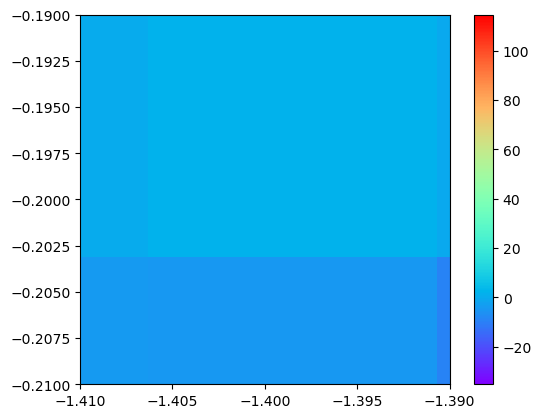

In [70]:
# Verification calc:
# r = (-1.4,-0.2,0.125) R_M, v centered at (600,450,-100) km/s
ds = fleks.load(str(dir+"3d_fluid_region0_2_t00000056_n00031082_amrex"))
dc = ds.get_slice("z",0.125)
Bx = np.array(dc.evaluate_expression("Bx")).T
By = np.array(dc.evaluate_expression("By")).T
Bz = np.array(dc.evaluate_expression("Bz")).T
plt.imshow(Bz,extent=[dc.x.value.min(),dc.x.value.max(),dc.y.value.min(),dc.y.value.max()],cmap="rainbow",origin="lower")
plt.xlim(-1.41,-1.39)
plt.ylim(-0.21,-0.19)
plt.colorbar()
Bmag = np.sqrt(50**2+35**2)
bhat = [-50/Bmag,-35/Bmag,0/Bmag]
vpara=600*bhat[0]+450*bhat[1]+100*bhat[2]
vperp=np.sqrt((600-vpara*bhat[0])**2+(450-vpara*bhat[1])**2+((-100)-vpara*bhat[2])**2)
print(vpara)
#np.sqrt(vpara**2+vperp**2)
#np.sqrt(600**2+450**2+100**2)

In [102]:
dc


-----------------------------
Variables       : ['Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez', 'X', 'Y', 'Z', 'ppcS0', 'ppcS1', 'pxxS0', 'pxxS1', 'pxyS0', 'pxyS1', 'pxzS0', 'pxzS1', 'pyyS0', 'pyyS1', 'pyzS0', 'pyzS1', 'pzzS0', 'pzzS1', 'rhoS0', 'rhoS1', 'uxS0', 'uxS1', 'uyS0', 'uyS1', 'uzS0', 'uzS1']

Data range      : [[unyt_quantity(-4., 'code_length'), unyt_quantity(1., 'code_length')], [unyt_quantity(-2., 'code_length'), unyt_quantity(2., 'code_length')], [0, 0]]

Data dimensions : (320, 256)


var        min               max               mean              
Bx        -8.989689e+01,   +7.326022e+01,   -3.159112e-02,   
By        -9.833852e+01,   +2.983603e+01,   -4.442357e+00,   
Bz        -3.527899e+01,   +1.145650e+02,   +1.171857e+00,   
Ex        -1.099704e+05,   +2.847433e+04,   -1.221578e+02,   
Ey        -3.638065e+04,   +8.272612e+04,   +2.497627e+03,   
Ez        -4.615901e+04,   +8.921016e+04,   +9.829271e+02,   
X         -3.492188e+00,   +0.000000e+00,   -6.365112e-01,   
Y    

In [59]:
Bx = np.array(dc.evaluate_expression("Bx").T)

In [61]:
Bx.shape

(256, 320)